In [1]:
#default_exp trainer

# A simple set of training classes

In [2]:
#export
import wandb
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader
from fastcore.all import *
from tqdm.notebook import tqdm
from accelerate import Accelerator

from hydranet.hydranet import HydraNet
from hydranet.data import NYUDataset

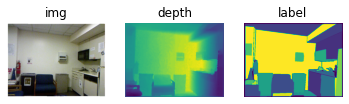

In [3]:
ds = NYUDataset()

ds.show_one()

In [4]:
#export
class Trainer:
    "A simple trainer using Accelerate"
    def __init__(self, dataloader, model, loss_func, eval_dataloader=None, fp16=False, wandb=False):
        store_attr()
        self.optimizer = None
        self.scheduler = None
        self.acc = Accelerator(fp16=fp16)
        if wandb:
            wandb.init(project="HydraNet")
    
    def prepare(self):
        self.model, self.optimizer, self.dataloader = self.acc.prepare(self.model, self.optimizer, self.dataloader)
    
    def one_batch(self):
        return next(iter(self.dataloader))
    
    def train_step(self, inputs, targets):

        # Forward pass ➡
        outputs = self.model(inputs)
        loss = self.loss_func(outputs, targets)

        # Backward pass ⬅
        self.optimizer.zero_grad()
        self.acc.backward(loss)
        
        # Step with optimizer
        self.optimizer.step()
        if self.scheduler is not None:
            self.scheduler.step()

        return loss
    

            
    

    
    def train_log(self, loss, example_ct, pbar):
        # Where the magic happens
        if self.wandb:
            wandb.log({"train_loss": loss}, step=example_ct)
        pbar.set_postfix({"Loss" : f'{loss:.3f}'})
    
    def train_one_epoch(self):
        for b in (pbar :=tqdm(self.dataloader, leave=False)):
            images, depths, labels = b
            loss = self.train_step(images, depths).item()
            self.example_ct +=  len(images)
            self.train_log(loss, self.example_ct, pbar)
        return loss
                           
    def eval_one_epoch(self, inputs, targets):
        self.model.eval()
        with torch.inference_mode():
            for b in tqdm(self.eval_dataloader, leave=False):
                # Forward pass ➡
                outputs = self.model(inputs)
                loss = self.loss_func(outputs, targets)
        
    def _fit(self, epochs=5):
        self.example_ct = 0
        self.prepare()
        for epoch in tqdm(range(epochs)):
            loss = self.train_one_epoch()
            print(loss)
            
    def fit(self, epochs=5, lr=1e-3):
        self.model.train()
        self.optimizer = Adam(self.model.parameters(), lr=lr)
        self._fit(epochs)
            
            
    def fit_one_cyle(self, epochs=5, lr=1e-3, max_lr=1e-1):
        self.model.train()
        self.optimizer = Adam(self.model.parameters(), lr=lr)
        self.scheduler = OneCycleLR(self.optimizer, 
                                    max_lr=max_lr, 
                                    steps_per_epoch=len(self.dataloader), 
                                    epochs=epochs)
        self._fit(epochs)

In [5]:
dl = torch.utils.data.DataLoader(ds, batch_size=8)

In [6]:
loss_func = nn.MSELoss()
model = HydraNet(num_classes=1)
trainer = Trainer(dl, model, loss_func, fp16=True)

In [7]:
b = trainer.one_batch()

b[0].shape, b[1].shape, b[2].shape

(torch.Size([8, 3, 480, 640]),
 torch.Size([8, 1, 480, 640]),
 torch.Size([8, 480, 640]))

In [8]:
trainer.fit(2, lr=1e-5)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

6.017712593078613


  0%|          | 0/182 [00:00<?, ?it/s]

3.338728904724121


In [42]:
trainer.fit_one_cyle(2, lr=1e-5, max_lr=1e-3)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

2.1790482997894287
4.759450197219849
7.906095266342163
10.611591339111328
13.707897186279297
14.384465217590332
15.165904104709625
15.754357099533081
16.286716878414154
16.952909648418427
21.587779700756073
32.51876229047775
35.74235314130783
46.17243641614914
54.06245297193527
55.23606079816818
56.03780037164688
56.91162729263306
57.594104647636414
58.05090346932411
59.0272111594677
60.64514335989952
61.05401557683945
61.628193378448486
62.80688238143921
63.7477633357048
64.68862235546112
66.86931145191193
73.26772463321686
78.66163837909698
85.60714972019196
88.19195926189423
89.74474573135376
93.4369101524353
102.81361246109009
105.05799198150635
107.48985576629639
110.77508783340454
114.50723719596863
117.09777522087097
118.40431272983551
122.35236942768097
123.5075581073761
126.53213024139404
127.79057538509369
129.69972133636475
131.37949132919312
133.11950516700745
135.1322751045227
136.6007457971573
139.90765511989594


KeyboardInterrupt: 

## Export -

In [ ]:
from nbdev.export import notebook2script
notebook2script()

Converted 01_data.ipynb.
Converted 02_layers.ipynb.
Converted 03_hydranet.ipynb.
Converted 04_trainer.ipynb.
Converted index.ipynb.
